# Data Assimilation

- Static version of slides: jrper.github.io/rv/da.html

j.percival@imperial.ac.uk

### Learning objectives for today

- Revise core probability theory
- Learn to identify and implement key data assimilation techniques
- Be able to describe their key properties

## Numerical weather prediction

 - Big user of HPC/supercomputing equipment
 - Solves massive, memory bounded problems
 - Key thing for the British to talk about

Why weather forecasting is studied
- Weather is somewhat predicable
- Weather is not totally predictable
- Weather is valuable

### ECMWF



### UK Met Office
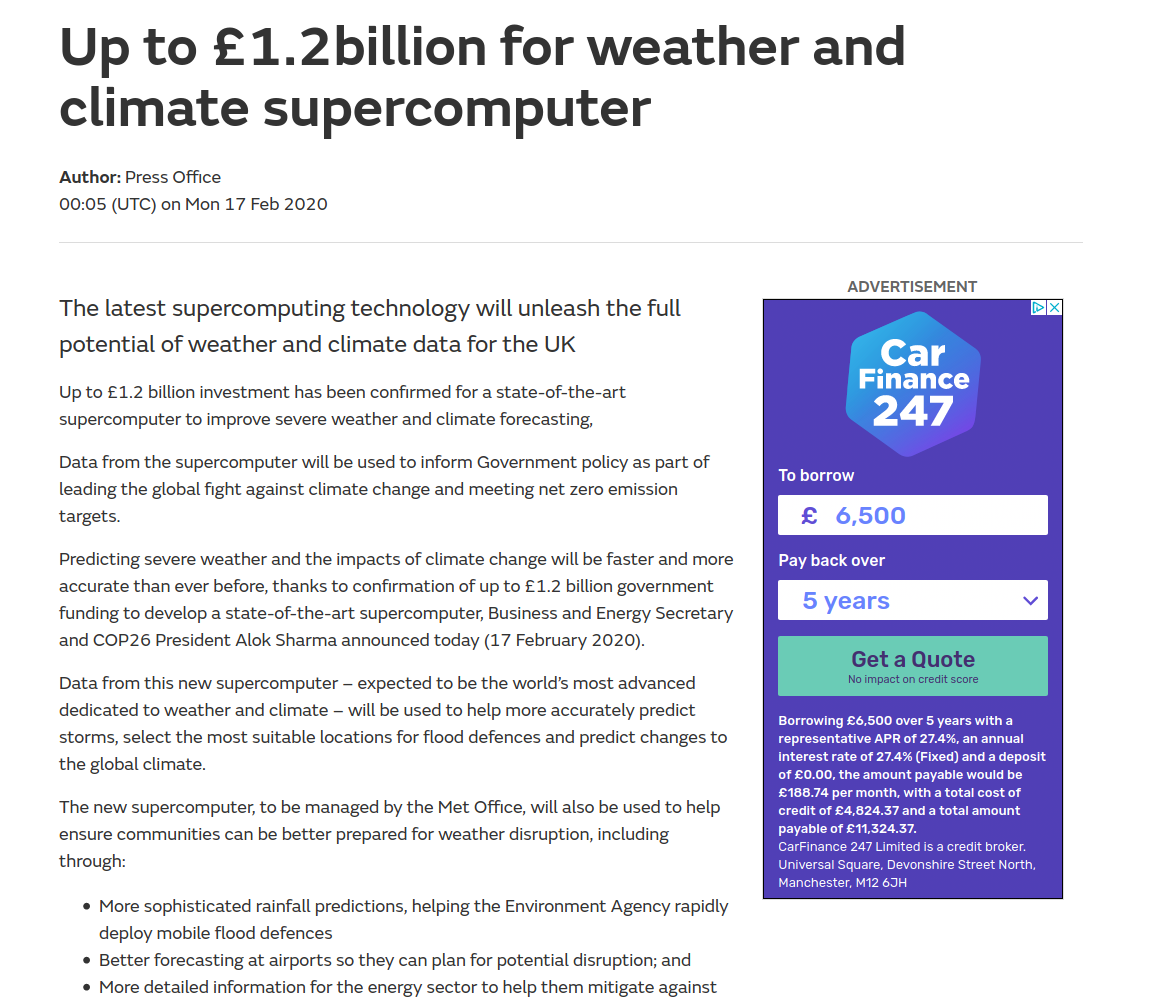

## Data Assimilation blends numerical models & observations

[From a blog post by a colleague in mathematics](http://www.cambridgeblog.org/2017/05/data-assimilation-in-every-day-life/)
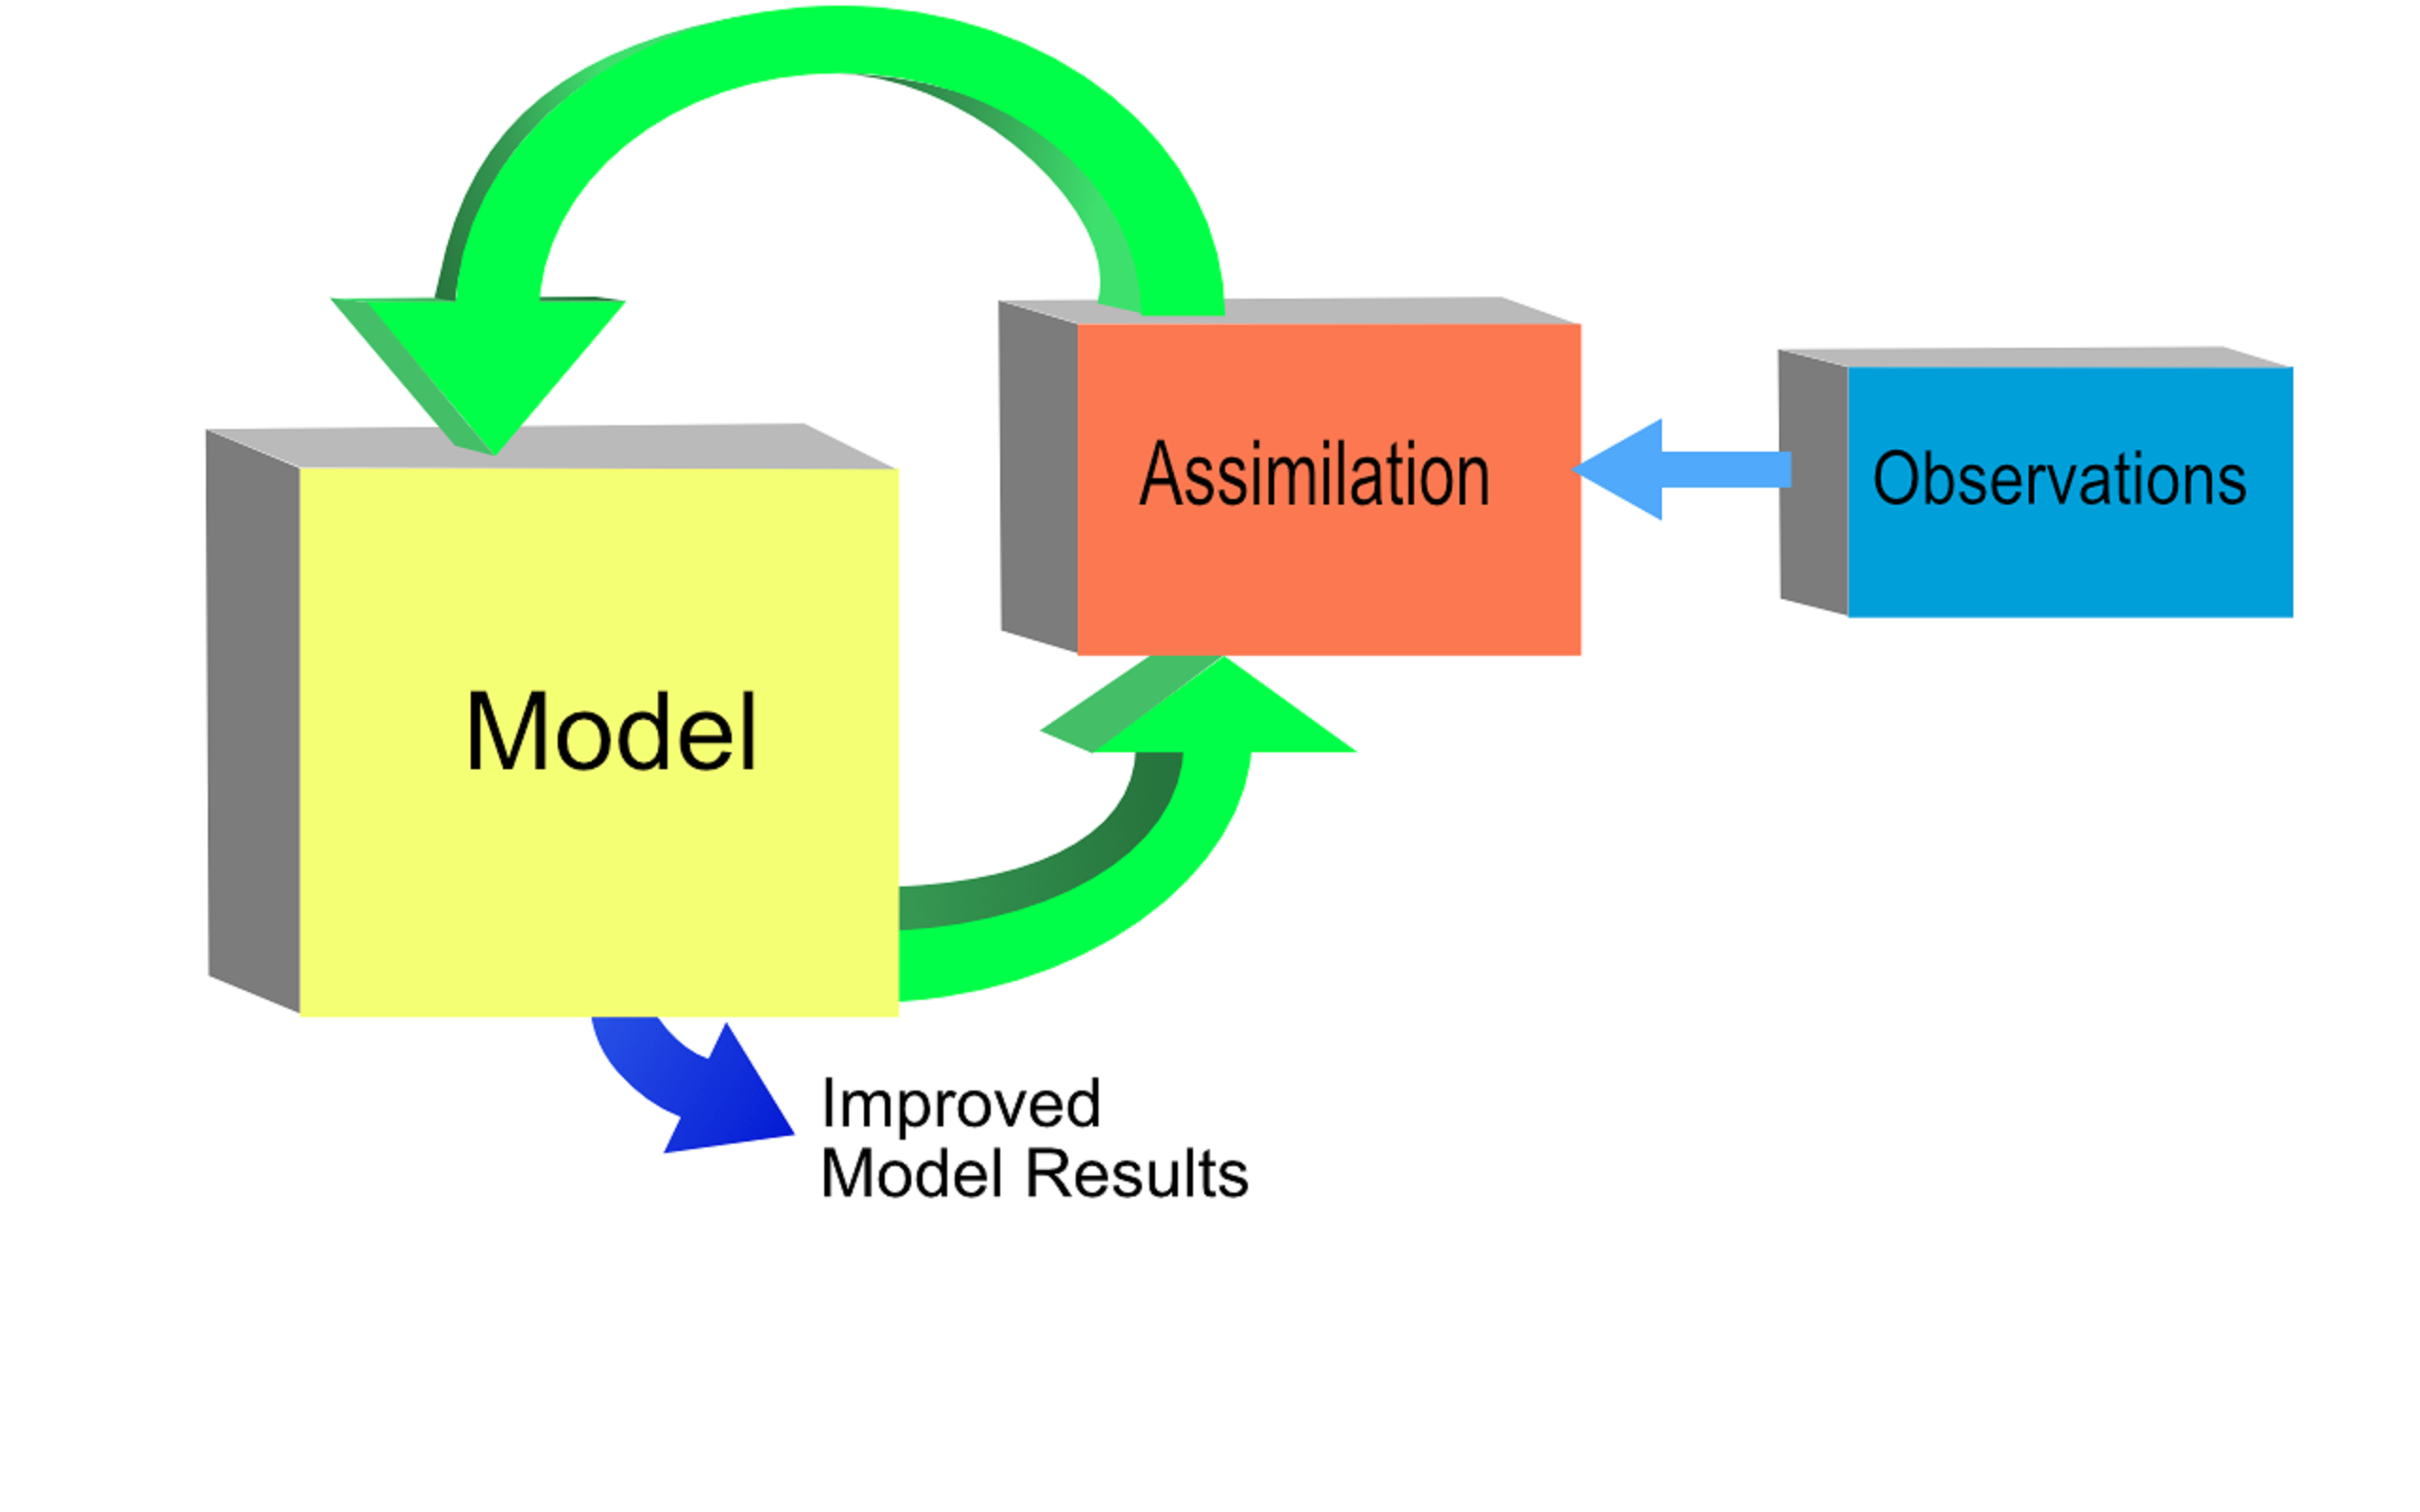


# Plan for the morning

- First section: Recap of Probability Theory
- Second section: Assimilating across space
- Third section: Assimilating across time

## Probability Theory

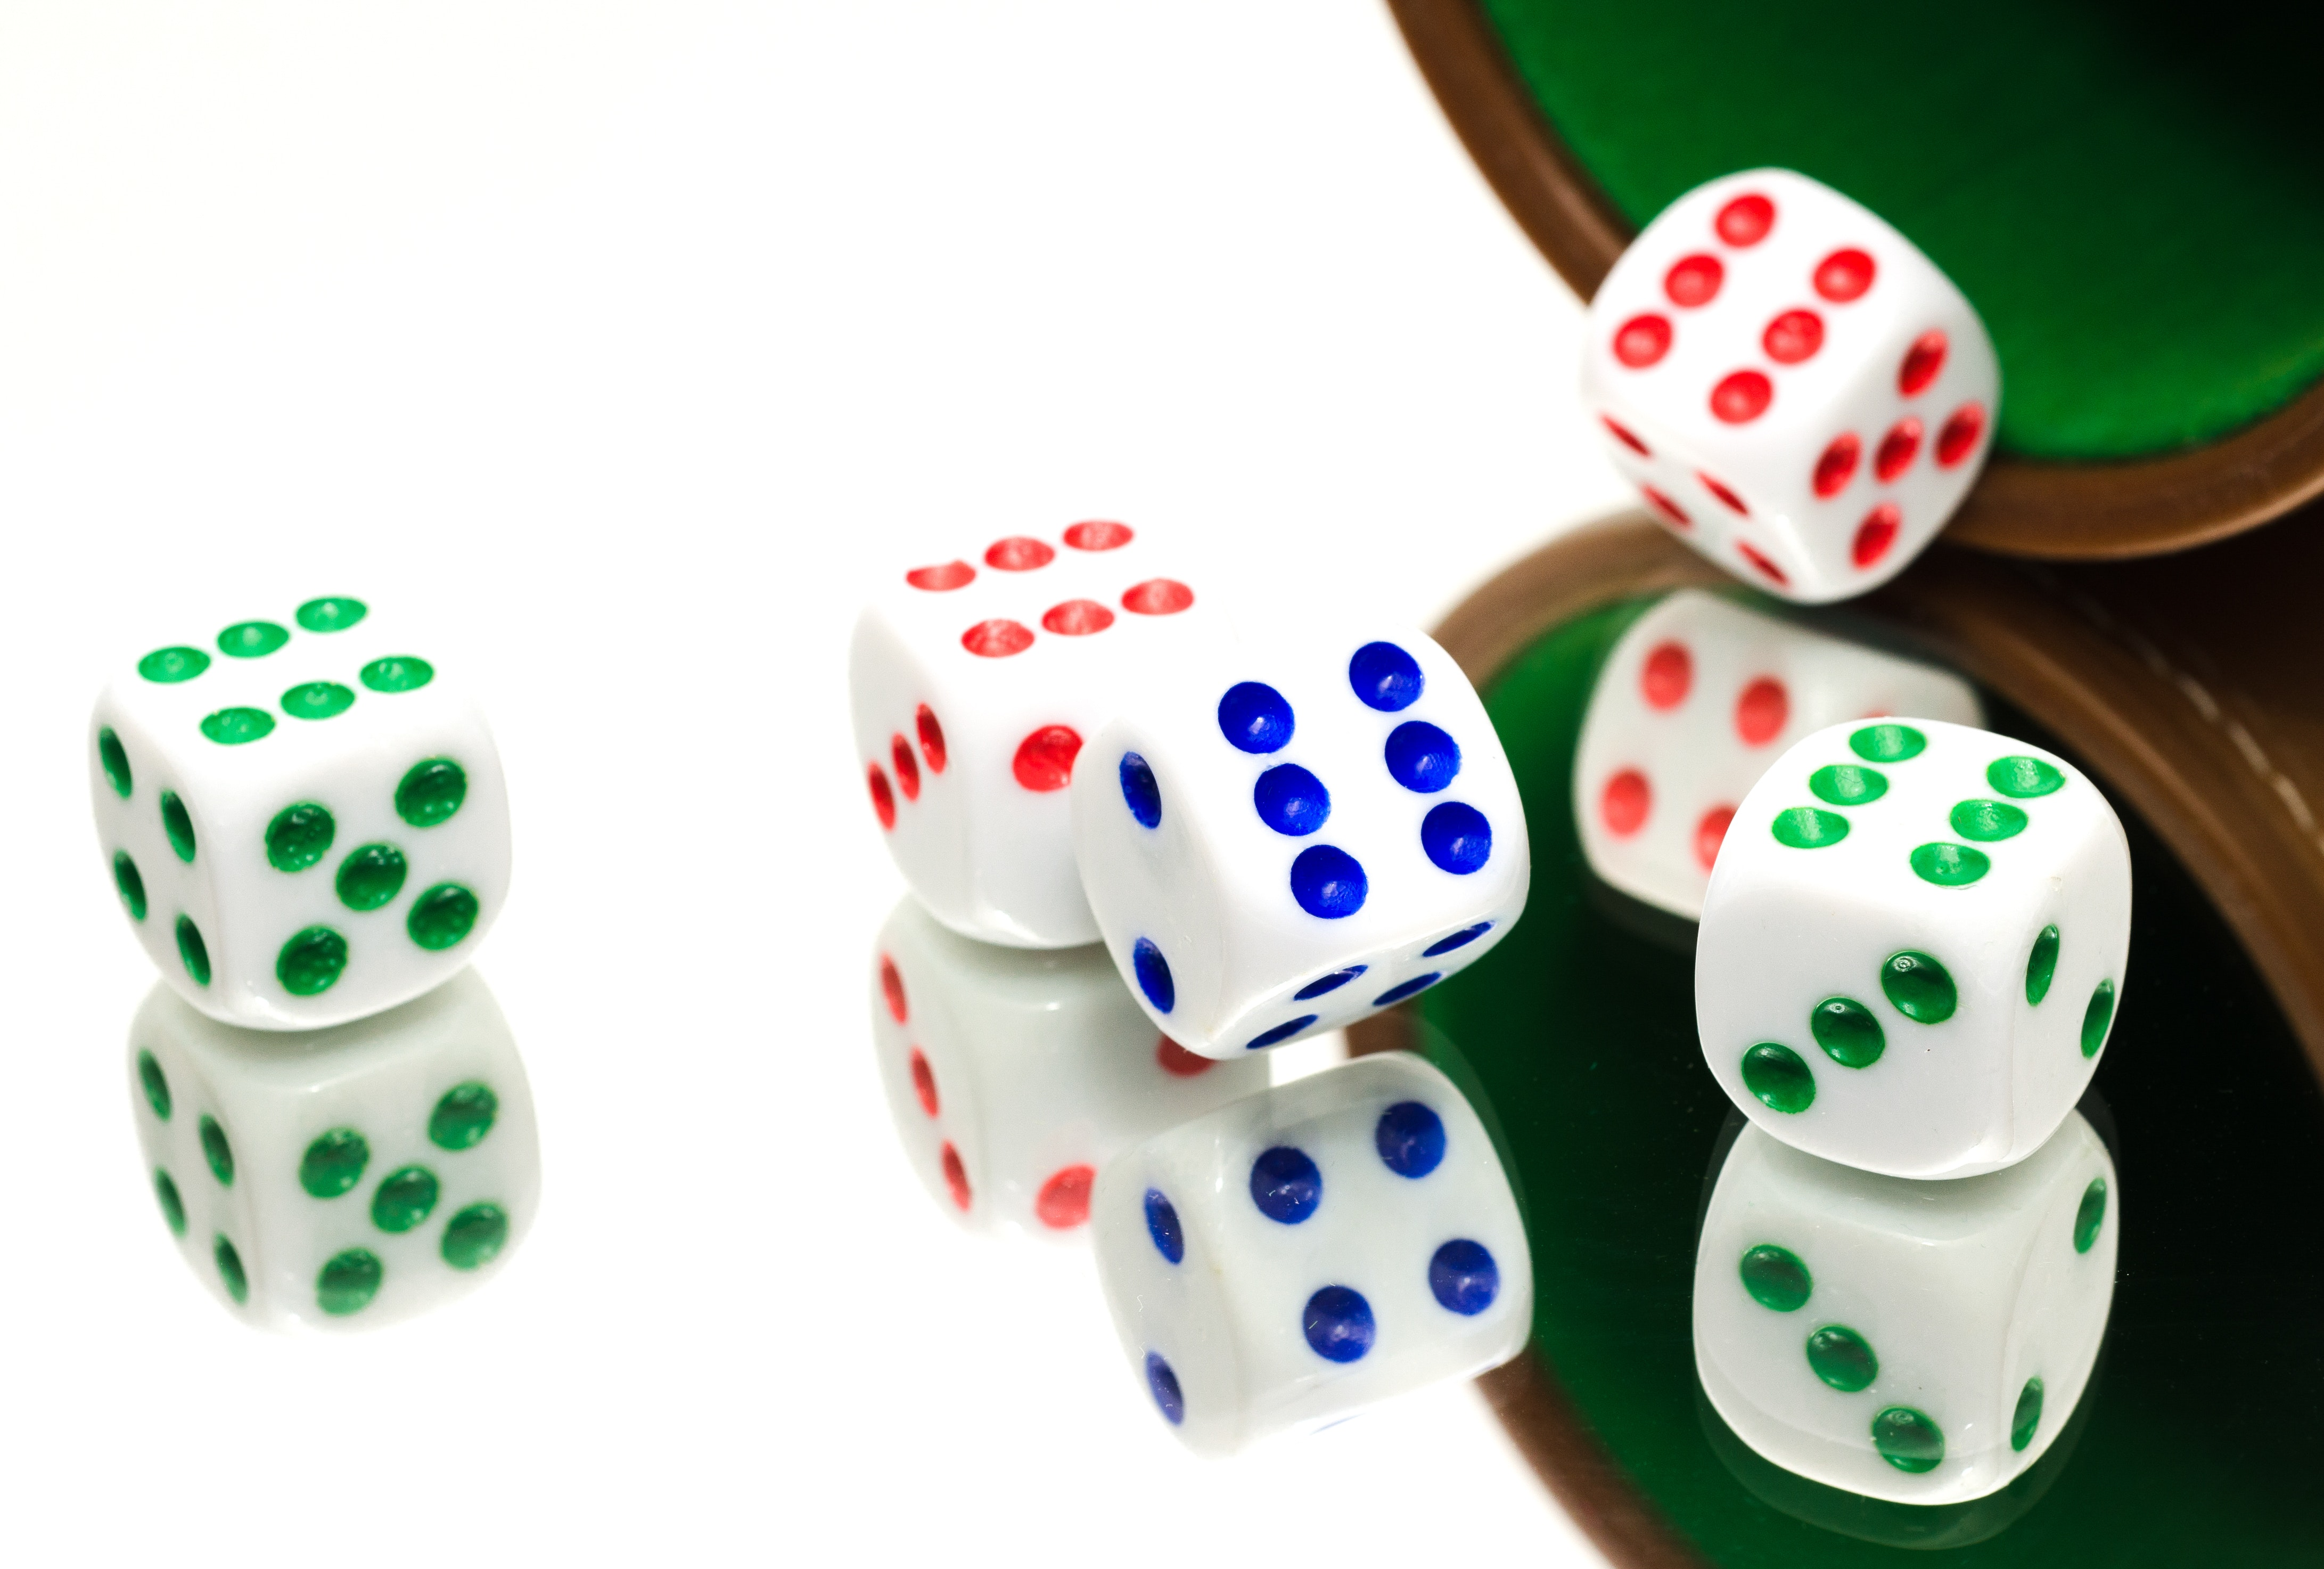

Traditional probability is ratio of successes to cases:

$$ \mbox{possible results} = \{1, 2, 3, 4, 5, 6\} $$

$$ \mbox{results divisible by 3} = \{3, 6\}$$

$$ P(\mbox{result divisible by 3}) = \frac{2}{6} \approx 0.3333 $$

In [ ]:
# Pythons standard random number library
import random
def d6():
    """A Python implementation of a six sized dice"""
    # We could also use numpy's np.random.randint(1, 7)
    # which will vectorize better.
    # note the different ways to set the endpoint
    return random.randint(1,6)

[d6() for _ in range(10)]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def sample():
    success = 0
    for i in range(1000):
        # successful trial divides by 3 
        success += (d6()%3 == 0)
    # return the ratio of successes to failures
    return success/1000

In [ ]:
plt.figure(figsize=(15,4))
plt.hist([sample() for _ in range(1000)]);

Discrete expected value operator, $E$

$$E(f(X)) := \sum_{\mbox{possible values}} f(x) P(X=x)$$

$$E(\mbox{6 sided dice}) := \sum_{x=1}^6 x \frac{1}{6}=3.5$$

### Mean and variance

$$\tag{mean}\mu_X:=E(X)$$
$$\tag{variance}\sigma^2_X := E((X-\mu)^2)$$
$$\quad\qquad=E(X^2)-E(X)^2$$

In [ ]:
import numpy as np
n_samples = 100
mu = []
for _ in range(1000):
    data = np.array([d6() for i in range(n_samples)])
    mu.append(np.sum(data)/n_samples) # or just np.mean()
plt.vlines(3.5, 0, 3)
plt.hist(mu, density=True);

Also,
$$\frac{\sum_{i=1}^n \left(x_i-\frac{\sum_{j=1}^n x_j}{n}\right)^2}{n}\approx \sigma^2_X$$

but
$$E\left(\frac{\sum_{i=1}^n \left(x_i-\frac{\sum_{j=1}^n x_j}{n}\right)^2}{n}-\sigma^2_X\right)=\frac{\sigma^2_X}{n}$$
Estimator is biased (i.e. estimator mean is not equal to real statistic)

a "better" (i.e unbiased) estimate for variance is
$$\frac{\sum_{i=1}^n \left(x_i-\frac{\sum_{j=1}^n x_j}{n}\right)^2}{n-1}$$
although for some variables this will tend to have a higher error.

In [ ]:

var_biased = []
var_unbiased = []
for _ in range(1000):
    data = np.array([d6() for i in range(n_samples)])
    var_biased.append((np.sum((data-mu[-1])**2)/n_samples)) # or np.var(a)
    var_unbiased.append((np.sum((data-mu[-1])**2)/(n_samples-1))) # or np.var(a, ddof=1)

In [ ]:
plt.hist(var_biased, density=True, alpha=0.5, label='biased')
plt.hist(var_unbiased, density=True, alpha=0.5, label='unbiased');
plt.legend()
plt.vlines(35/12, 0, 2);

## Independence, correlation and covariance


Given two random variables $X$ & $Y$, can define joint (vector) probability

$$ P(X=x\mbox{ and }Y=y) $$

The vectors are independent if for all $x, Y$
$$ P(X=x\mbox{ and }Y=y) = P(X=x)P(Y=y)$$

Let $E(X)=\mu_X$, $E(Y)=\mu_Y$, can define covairiance (see also lecture 2 tutorial)
$$\mbox{cov}(X,Y) = E((X-\mu_X)(Y-\mu_y) = E(XY)-\mu_X\mu_Y$$
$$0\leq\mbox{cov}(X,Y)^2\leq\sigma_X^2\sigma_Y^2$$

Can also define correlation
$$ \mbox{cor}(X,Y) = \frac{\mbox{cov}(X,Y)}{\sigma_X\sigma_Y} $$
Hence
$$ -1 \leq \mbox{cor}(X,Y) \leq 1 $$

In [ ]:
from IPython.display import display_html, IFrame
display_html(IFrame("https://tylervigen.com/view_correlation?id=3890",1200, 800))

## Properties of the expectation operator

$$E(10) = 10$$
$$E(3X) = 3E(X)$$
$$ E(X+Y) = E(X)+E(Y) $$

Full proofs surprisingly involved (and we wouldn't expect you to write it down from scratch)

$$ E(X+Y) = \sum_{x,y} (x+y)P(X=x\cap Y=y)$$
$\sum_{x,y} x P(X=x\cap Y=Y)=\sum_{x,y} xP(x)(Y=y\vert X=x) $$
$$=\sum_x \left[xP(x)\sum_y(P(y\vert x\right] $$
$$=E(X)$$

## Random integers on a computer

Two kinds of "randoms on computers

 1. Pseudo-random/deterministic (PRNGs)
 2. Hardware/True random (TRNGs)
 
 

#### PRNGS

- Each "random" number in sequence derived by a rule from previous.
- Hard to guess, but not "surprising"
- "Cheap" to generate
- Reproducable.

In [ ]:
# A (bad) example
class Randu:
    """Never EVER use this for anything non-trivial"""
    
    def __init__(self, seed=1):
        
        self._I = seed
        
    def __call__(self):
        self._I = (65539*self._I)%(2**31)
        return self._I
 
randu = Randu(1)

print([randu() for _ in range(5)])
randu = Randu(2)
print([randu() for _ in range(5)])

In [ ]:
randu_data = [randu() for _ in range(2**11)]
# randint uses https://en.wikipedia.org/wiki/Mersenne_Twister
random_data = [random.randint(0,2**31-1) for _ in range(2**11)]
plt.hist(randu_data, 32, alpha=0.5, label='Randu')
plt.hist(random_data, 32, alpha=0.5, label='randint')
plt.legend();

#### TRNGs

- Use external source to seed PRNG
- Can't be guessed based on previous data
- Higher cost to implement
- USeful for cryptography/security

In [ ]:
### An example interaction with a TRNG
import os
b = os.urandom(4)
print(b)
# Here "big" means https://en.wikipedia.org/wiki/Endianness#Big-endian
int.from_bytes(b, 'big')

## Continuous Probability

- Pick a real number at total random between 0 & 4.
- What's the chance it's $pi$?
- Complicated question
$$\frac{\{\pi\}}{\{1, 2, 1.5, e, \ldots\}} = 0$$

- Whats the chance $X\leq2$?
- Better question
- Half  numbers smaller than 2, half bigger
$$P(X\leq 2) =\frac{1}{2}$$

# Cumulative distribution function

$$ F(z)=P(x<z)= \left\{\begin{array}{cc}
0& z<0,\\
\frac{z}{4}& z\leq 0<4,\\
1 & z\geq4.
\end{array}\right.
$$

In [ ]:
# Plot the CDF of a uniform 
N = 2000
X = np.random.uniform(0,4,(20, N))
for x in X:
    for y in [0, 1, 2, 3, 4]:
        plt.scatter(y,sum(x<y)/N)
        
plt.plot([0,4],[0,1]);

## Probability Density function

 - If we're lucky
$$ F(z) = \int_{-\infty}^z p(x) dx .$$
- $p(s)$ is probability density function (PDF)
- We're lucky for surprisingly many distributions

### Continuous expectation

$$ E(f(x)) = \int_{-\infty}^\infty f(x) p(x) dx$$

- Core discrete properties hold
- Includes definitions of mean and variance.

## The Gaussian Distribution

 - Classic Bell curve function
$$ p(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left( - \frac{(x-\mu)^2}{2\sigma^2} \right) $$

In [ ]:
# Plot the CDF and PDF for the Gaussian distribution
x = np.linspace(-4,4, 51)

#PDF
def p_x(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x, p_x(x))
plt.fill_between(x[:26], p_x(x[:26]), fc='r')

In [ ]:
from scipy.special import erf
# CDF
plt.subplot2grid((1, 2), (0, 0))
plt.plot(x, 0.5*(1+erf(x)))
plt.plot(0, 0.5*(1.0+erf(0)), 'ro')

- Sum of Gaussians is Gaussian
$$p_{X+Y}  = \frac{1}{\sqrt{2\pi(\sigma_X^2+\sigma_Y^2)}}\exp \left( -\frac{(x-\mu_X-\mu_Y)^2}{2(\sigma^2_X+\sigma^2_Y)} \right) $$
- Not true for other distributions!
- Not true for multiplication/nonlinear functions

## Multivariate Gaussian

- Consider vector, $\mathbf{z}$ of independent $\mathcal{N}(0,1)$ normal distributions.
- Joint distribution
$$p(\mathbf{z}) = \frac{1}{\sqrt{2\pi}}\exp\left(\frac{\|\mathbf{z}\|^2}{2}\right) $$

$$ P(Z_1\leq z_1, \ldots Z_n\leq z_n) = \int_{-\infty}^{z_1} \ldots \int_{-\infty}^{z_n} p(\mathbf{z}) dz_n \ldots dz_1 $$.

Under linear transformation $\mathbf{x} = \mathbf{A}\mathbf{z}+\mathbf{c}$ we will find
$$ \mbox{cov}(\mathbf{x}, \mathbf{x}) = \mathbf{A}\mathbf{A}^T$$
and 
$$p(\mathbf{z}) = \frac{1}{\sqrt{2\pi\mbox{det}(\mathbf{A}\mathbf{A}^T)}}\exp\left(\frac{(\mathbf{x}-\mathbf{c})^T(\mathbf{A}\mathbf{A}^T)^{-1}(\mathbf{x}-\mathbf{c})}{2}\right).$$
- Fully determined by means & covariance matrix. 

## Bayes Theorem

$$ \tag{conditional probability} P(X\cap Y) = P(X)P(Y\vert X) = P(Y)(X\vert Y)$$

If $P(Y) \neq 0$ then
$$ \tag{Bayes Theorem} P(X\vert Y) = \frac{P(X)P(Y \vert X)}{P(Y)} $$

## Random reals on a computer

- The heart of an RNG is almost always for integers
- Usually also between 0 and some $N_\max$
- To get other distributions we must do sums

In [ ]:
class RealRandu(Randu):
    """Real uniform random number generator based on RANDU."""

    def __call__(self):
        super().__call__();
        return self._I/(2**31)
    
randr = RealRandu()
data = [randr() for _ in range(9999)]
plt.hist(data, density=True);

In [ ]:
### Now for the true evil of Randu!
from mpl_toolkits.mplot3d import Axes3D
rand = Randu(1)
data = [rand() for _ in range(39999)]
data = np.array(data).reshape((len(data)//3, 3)).T
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data)

ax.azim = -134; ax.elev =38

In [ ]:
# What about Gaussians?

N = 100000
a = np.random.uniform(size=N)
b = np.random.uniform(size=N)

plt.hist(a, density=True, alpha=0.4)
plt.hist(b, density=True, alpha=0.4)
plt.hlines(1.0, 0.0, 1.0);

In [ ]:
#A python demonstration of the Box-Muller algorithm

def box_muller(a, b):
    r = np.sqrt(-2*np.log(a))
    theta = 2*np.pi*b
    return r*np.sin(theta), r*np.cos(theta)
n1, n2 = box_muller(a, b)
plt.hist(n1, density=True, alpha=0.4)
plt.hist(n2, density=True, alpha=0.4)
x = np.linspace(-4, 4)
def p_x(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x, p_x(x));

## First break

let's take 10 minutes

## Data Assimilation: a good reference

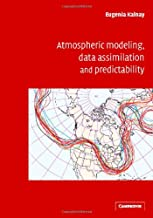

Eugenia Kalnay - Atmospheric modeling, data assimilation and predicability

## The Language of data assimilation

A paper (Ide et al. 1997) sets out the standard notation:

$$ \mathbf{x} : \mbox {vector of state variables (model)} $$
$$ \mathbf{y} : \mbox{vector of  observations (data)}$$

#### States
$$ \mathbf{x}_b : \mbox {Background state}$$
$$ \mathbf{x}_a : \mbox {Analysis state}$$
$$ \mathbf{x}_t : \mbox {Analysis state}$$
#### Observations & models
$$ \mathbf{H}, h: \mbox{ observation operator}$$
$$ \mathbf{M}, m: \mbox{forward model}$$

#### Errors
$$ \mathbf{e}_b:= \mathbf{x}_b-\mathbf{x}_t : \mbox {Background error}$$
$$ \mathbf{e}_a:= \mathbf{x}_a-\mathbf{x}_t : \mbox {Analysis error}$$
$$ \mathbf{e}_o:= \mathbf{y}-\mathbf{h}(\mathbf{x}_t) : \mbox {Observation error}$$

#### Error covariance matrixes

$$ \mathbf{B}:=E(\mathbf{e}_b\mathbf{e}_b^T): \mbox{Background}$$
$$ \mathbf{P}:=E(\mathbf{e}_a\mathbf{e}_a^T): \mbox{Analysis}$$
$$ \mathbf{R}:=E(\mathbf{e}_o\mathbf{e}_o^T):\mbox{Observations}$$

## Nudging: the first DA method

Numerics normally updates $\mathbf{x}$ through differential/difference equation
$$\frac{\partial \mathbf{x}}{\partial t} = \mathbf{m}(\mathbf{x})$$

#### Nudging

Given direct observation, $\mathbf{y}$ update via fictional force

$$\frac{\partial \mathbf{x}}{\partial t} = \mathbf{m}(\mathbf{x})\color{red}{+\frac{\alpha}{\Delta t}(\mathbf{y}-\mathbf{x})}$$

*not* a brilliant method:
 - only direct observations
 - fake heating drives spurious circulations
 - point updates only.
 
 Lets get statistical

## Statistical interpolation
#### The time from two clocks

- Suppose you have two clocks
 * First says it's 10:21 and 95% of the time its $\pm 2$ minutes
 * Second says it's 10:24 and 95% of the time its $\pm 1$ minutes
- What's the time?

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity
- Unbiased : Error has zero mean

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity
- Unbiased : Error has zero mean
- Linear: $T_\mbox{guess} = a T_1 + b T_2$

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity
- Unbiased : Error has zero mean
- Linear: $T_\mbox{guess} = a T_1 + b T_2$
- Best: minimise __mean square error__

$$ T_1 = T_t+e_1 $$
$$ T_2 = T_t+e_2 $$
$$ T_\mbox{guess} = (a+b) T_t + a e_1 +b e_2 $$
$$ e_\mbox{guess} := T_\mbox{guess}-T_t = (a+b-1)T_t + ae_1+be_2 $$

$$ E(e_\mbox{guess}) := (a+b-1)T_t + aE(e_1)+bE(e_2) $$
- If $e_1$ & $e_2$ unbiased want
$$ a+b = 1$$
 for estimate to be unbiased - constraint.
- If observations are also independent
$$E(e^2_\mbox{guess}) = a^2E(e_1^2) +b^2 E(e_2^2)$$

- Substitute for $b$ and variances:
$$E(e^2_\mbox{guess} = a^2\sigma_1^2 +(1-a)^2 \sigma_2^2$$
- Minimise w.r.t $a$
$$\frac{df}{da}= 2a\sigma_1^2 -2(1-a)\sigma_2^2 $$
- i.e.
$$ a = \frac{\sigma_2^2}{\sigma_1^2 +\sigma_2^2} $$
$$ T_\mbox{BLUE} = \frac{\sigma^2_2 T_1+\sigma_1^2 T_2}{\sigma^2_1+\sigma^2_2} $$

In [ ]:
# We'll make the truth the zero state 
T_true = 0.0
T_1 = T_true + np.random.normal(0, scale=2, size=1000)
T_2 = T_true + np.random.uniform(-np.sqrt(3),np.sqrt(3), size=1000)
def T_guess(a):
    """Function to generate zero bias """
    return a*T_1+(1-a)*T_2
x=np.linspace(0,1)
e_guess = [np.mean((T_guess(_)-T_true)**2) for _ in x]

plt.plot(x, e_guess, label='mean error from 1000 trials')
plt.plot(1**2/(1**2+2**2),(1**2*2**2)/(1**2+2**2),'ko', label='Predicted minimum mean square error');
plt.xlabel('Weighting'); plt.ylabel('Mean square error'); plt.legend();

### Optimal Interpolation
Now do a vector version

New information (aka *innovation*) is $\mathbf{y}-\mathbf{H}\mathbf{x}$.

Want new $\mathbf{x}_a=\mathbf{x}_b+\mathbf{W}(\mathbf{y}-\mathbf{H}\mathbf{x})$

Choose to minimise total analysis mean square error
$$\tag{mean square error} E(\mathbf{e}_a\cdot\mathbf{e}_a)$$

$$ \mathbf{e}_a = \mathbf{e}_b +\mathbf{W}(\mathbf{e}_o-\mathbf{H}\mathbf{e}_b)$$
Normal equation
$$E\left(\left[\mathbf{e}_b +\mathbf{W}(\mathbf{e}_o-\mathbf{H}\mathbf{e}_b\right](\mathbf{e}_o-\mathbf{H}\mathbf{e}_b)^T\right)=\mathbf{0}.$$
Assume errors are unbiased and no correlations between $\mathbf{e}_b$ and $\mathbf{e}_o$.
$$E(\mathbf{e}_b\mathbf{e}_b^T)\mathbf{H}^T+\mathbf{W}\left(E(\mathbf{e}_o\mathbf{e}_o^T)+\mathbf{H}E(\mathbf{e}_b\mathbf{e}_b^T)\mathbf{H}^T\right)=\mathbf{0}$$

$$\mathbf{B}\mathbf{H}^T+\mathbf{W}\left(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T\right)=\mathbf{0}$$
- Optimal (Kalman) gain
$$\mathbf{W}=\mathbf{B}\mathbf{H}^T\left(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1}$$
- Optimal analysis
$$\mathbf{x}_a=\mathbf{x}_b+\mathbf{B}\mathbf{H}^T\left(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1}(\mathbf{y}-\mathbf{H}\mathbf{x}_b)$$

In [ ]:
### Example optimal interpolation implementation & solution
from scipy.linalg import inv
### define the standard deviation of the background and observations

sigma_t = 1.0; sigma_b = 1.0; sigma_r = 1.0
l_t = 0.2; l_e = 0.1; l_b = l_e
s = np.linspace(0, np.pi)

e_b = np.zeros(len(s));  x_t = np.zeros(len(s))
for _ in range(len(s)):
    e_b += np.random.normal(0, sigma_b)*np.exp(-(s-s[_])**2/l_e**2)
    x_t += np.random.normal(0, sigma_t)*np.exp(-(s-s[_])**2/l_t**2)
x_b = x_t + e_b

In [ ]:
H = np.zeros((len(s)//5, len(s)))
for _ in range(H.shape[0]):
    H[_,5*_] = 1
    
y = np.dot(H, x_t) 
y += np.random.normal(0, 1, size=(y.shape))
R = sigma_r**2*np.eye(y.shape[0])

s2 = np.broadcast_to(s, (len(s), len(s)))
## Here we calculate B from known statistics 
B = sigma_b**2*np.exp(-(s2-s2.T)**2/l_b**2)

W = B.dot((H.T)).dot(inv(R+H.dot(B.dot(H.T))))
x_a = x_b + W.dot(y-H.dot(x_b))

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(s, x_t, 'k', label='$x_t$, true state')
plt.plot(s, x_b, 'b', label='$x_b$, background guess')
plt.scatter(s[::5], y, label='obervation')
plt.plot(s, x_a, 'r', label='$x_a$, final analysis')
plt.legend();

#### Good things:
- Can use single $\mathbf{B}$
- If $\mathbf{x}$ is longer than $\mathbf{y}$ matrix to invert is probably small
#### Bad things:
- No time dependence
- Linear $\mathbf{H}$ only

## Spatial Variational Assimilation: 3D-Var

- Assume all errors are multivariate Gaussian
- Assume Observations and state vector are independent
- Look for most likely (i.e highest pdf state)
- Bayes' Theorem plus independece:

$$ p(\mathbf{x}\vert\mathbf{y}) = \frac{p(\mathbf{y}\vert\mathbf{x})p(\mathbf{x})}{P(\mathbf{y})} $$

$$p(\mathbf{x}\vert\mathbf{y}) \propto \exp\left(-\frac{(\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x})-(\mathbf{y}+\mathbf{h}(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x}))}{2}\right) $$

Sufficient to *minimize*
$$J(\mathbf{x}) = (\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b+\mathbf{x})+(\mathbf{y}-\mathbf{h}(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x}))$$

In [ ]:
# Example 3D-Var implementation and solution
# We will use some weather-like 2d data and generate the B from climatology.

nx = 26; ny = 11
Lx = 1e6; Ly = 4e5
U_0 =  30.0; radius = 5e4

def wind_field(X, Y, circulations, centres):
    U = np.full((ny, nx), U_0)
    V = np.zeros((ny, nx))
    for circ, (x, y) in zip(circulations, centres):
        r2= (X-x)**2 + (Y-y)**2
        u = circ/(2*np.pi)*np.where(r2>radius**2, 1./r2, 1.0/radius**2) 
        U -= (Y-y)*u
        V += (X-x)*u
    return U, V
X, Y = np.meshgrid(np.linspace(0,Lx,nx), np.linspace(0,Ly, ny))

def random_vortices(N, kx=5, ky=5):
    return (200*np.random.lognormal(0, 0.1, size=N)*radius,
            np.random.uniform([-kx*radius, -kx*radius], [Lx+ky*radius, Ly+ky*radius], (N, 2)))

In [ ]:
def plot_wind(X, Y, u, v):
    plt.figure(figsize=(15,5))
    plt.quiver(X, Y, u, v, np.sqrt(u**2+v**2))
    plt.colorbar()
    plt.axis('equal')
U_t, V_t = wind_field(X, Y, *random_vortices(4, -1, -1))
plot_wind(X, Y, U_t, V_t);

In [ ]:
# observation locations
n_full = 25
n_speed = 25
y_loc = np.random.randint(0, nx*ny, n_full+n_speed)
# observation values
y = np.empty(2*n_full+n_speed)
y[:n_full] = U_t.ravel()[y_loc[:n_full]] + np.random.normal(0, 2.0, n_full)
y[n_full:2*n_full] = V_t.ravel()[y_loc[:n_full]] + np.random.normal(0, 2.0, n_full)
y[2*n_full:] = (np.sqrt(U_t.ravel()[y_loc[n_full:]]**2
                      + V_t.ravel()[y_loc[n_full:]]**2)
                      + np.random.normal(0, 2, n_speed))

In [ ]:
def h(x):
    hx = np.empty(2*n_full+n_speed)
    u = x[y_loc]
    v = x[ny*nx+y_loc]
    hx[:n_full] = u[:n_full] = u[:n_full]
    hx[n_full:2*n_full] = v[:n_full]
    hx[2*n_full:] = np.sqrt(u[n_full:]**2+v[n_full:]**2)
    
    return hx

R = 2.0**2*np.eye(2*n_full+n_speed)

plt.figure(figsize=(15,5))
plt.scatter(X.ravel()[y_loc[:n_full]], Y.ravel()[y_loc[:n_full]], c='r')
plt.scatter(X.ravel()[y_loc[n_full:]], Y.ravel()[y_loc[n_full:]], c='k')
plt.axis([0, Lx, 0, Ly]);

In [ ]:
U = np.empty((5000,ny,nx)); V = np.empty((5000,ny,nx))
for _ in range(U.shape[0]):
    U[_, : :], V[_, :, :] = wind_field(X, Y, *random_vortices(4))
mu_u = np.mean(U, 0); mu_v = np.mean(V, 0)
plot_wind(X, Y, mu_u, mu_v)

In [ ]:
d = np.empty((U.shape[0], 2*ny*nx))
for _ in range(d.shape[0]):
    d[_, :ny*nx] = (U[_, :]-mu_u).ravel() 
    d[_, ny*nx:] = (V[_, :]-mu_v).ravel()
B = np.empty((2*nx*ny, 2*nx*ny))
for i in range(2*nx*ny):
    for j in range(2*nx*ny):
        # We'll be good and use the unbiased (N-1) form of the covariance
        B[i, j] = np.sum(d[:, i]*d[:, j])/(U.shape[0]-1)
plt.figure(figsize=(15,5))
plt.pcolormesh(X, Y, B[ny//2*nx+nx//2, :ny*nx].reshape((ny,nx)))
plt.colorbar();

In [ ]:
x_b = np.empty(2*ny*nx) 
x_b[:ny*nx] = mu_u.ravel(); x_b[ny*nx:] = mu_v.ravel()

Binv = inv(B); Rinv = inv(R)

def J(x):
    dx_b = x-x_b
    dx_o = y - h(x)
    return np.dot(dx_b, Binv.dot(dx_b))+np.dot(dx_o,Rinv.dot(dx_o))

from scipy.optimize import minimize
res = minimize(J, x_b, method='CG', tol = 1e-3, options={'maxiter':20})
x_a = res.x

U_a = x_a[:ny*nx].reshape((ny,nx))
V_a = x_a[ny*nx:].reshape((ny,nx))

In [ ]:
# first-guess - climatography
plot_wind(X, Y, mu_u, mu_v)

In [ ]:
# real state
plot_wind(X, Y, U_t, V_t)

In [ ]:
# our analysis
plot_wind(X, Y, U_a, V_a)

#### Good things:
- Can use single $\mathbf{B}$
- Can apply standard minimization techniques
- Allows nonlinear observations
#### Bad things:
- No time dependence
- Iteration to nonlinear solution more costly

## Two names, same outcome

If $\mathbf{h}(\mathbf{x})$ linear (i.e. $\mathbf{h}(\mathbf{x})=\mathbf{H}\mathbf{x}$)

then for 3D-Var

$$\mathbf{x}_a = \mathbf{x}_b + \left(\mathbf{B}^{-1}+\mathbf{H}^T\mathbf{R}^{-1}\mathbf{H}\right)^{-1}\mathbf{H}^T\mathbf{R}^{-1}[\mathbf{y}-\mathbf{H}\mathbf{x}_b] $$
Actually same as OI!

In this case

$$J(\mathbf{e})=\|\mathbf{e}-\mathbf{e}_b\|^2_{\mathbf{B}}+\|\mathbf{H}\mathbf{e}-\mathbf{e}_o\|^2_{\mathbf{R}} $$
for norms

$$\|\mathbf{a}\|^2_{\mathbf{M}}=\mathbf{a}^T\mathbf{M}^{-1}\mathbf{a}$$

Can view as special case of regularization!

## Second Break

## Time in the assimilation process

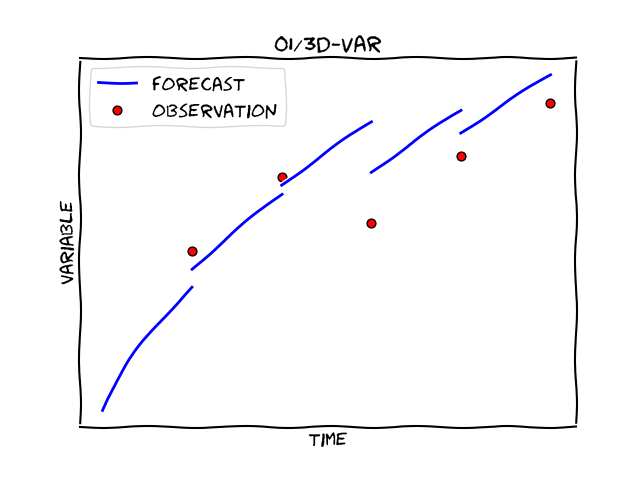

## The Kalman Filter

- Consider a system with a known linear forward model $\mathbf{M}$
$$\mathbf{x}^{k+1}_t = \mathbf{M}\mathbf{x}^k_t + \mathbf{f},$$
- forecast is
$$\mathbf{x}^{k+1}_b = \mathbf{M}\mathbf{x}^k_a +\mathbf{f}_b,$$
- error is
$$\mathbf{e}_b^{k+1} = \mathbf{M}\mathbf{e}^k_a +\mathbf{e}_f$$

- Error covariances go like
$$\mathbf{B}^{k+1} =  E(\mathbf{e}_b^{k+1}[\mathbf{e}_b^{k+1}]^T) $$
$$\qquad \qquad \qquad= \mathbf{M}E(\mathbf{e}_b^k[\mathbf{e}_b^k]^T)\mathbf{M}^T+E(\mathbf{e}_f[\mathbf{e}_f]^T)$$
$$\qquad = \mathbf{M}\mathbf{P}^k\mathbf{M}^T+\mathbf{Q}$$

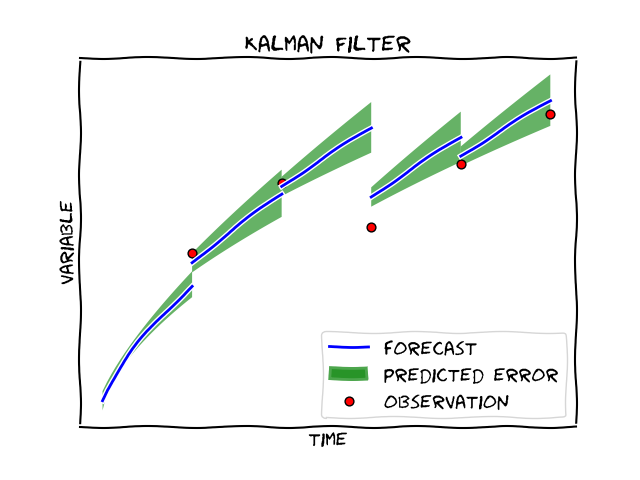

Four stage process
1. Use model to update analysis into  forecast
$$ \mathbf{x}^{k+1}_b = \mathbf{M}\mathbf{x}^k_a+\mathbf{f}_b$$
2. Use model to update analysis error covariance into forecast error covariance
$$\mathbf{B}^{k+1} = \mathbf{M}\mathbf{P}^k\mathbf{M}^T +\mathbf{Q}$$
3. Use observation innovations to optimally update forecast into analysis,
$$ \mathbf{x}^{k+1}_a = \mathbf{x}^{k+1}_b + \mathbf{B}^{k+1} \mathbf{H}^T\left( \mathbf{R}^{k+1} + \mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1} (\mathbf{y}^{k+1}-\mathbf{H}\mathbf{x}^{k+1}_b).$$
4. Calculate the analysis error covariance.
 $$\mathbf{P} = (\mathbf{I}-\mathbf{B}\mathbf{H}^T(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T)^{-1}\mathbf{H})\mathbf{B}.$$

#### Good things:
- Always have most appropriate $B$
- Know error bounds
- Most accurate approach
#### Bad things:
- Calculating new $B$ **really** costly
- Information only carried forwards, not back.

## Temporal Variational Assimilation: 4D-Var

- 4D-Var is time-aware equivalent of 3D-Var method 
- Assuming observation and background errors fGaussian.
- Look for initial state vector, $\mathbf{x}_0$, maximizing the joint probability density over "time window"

$$ p(\mathbf{x}_0\vert \mathbf{y}) \propto \exp\left(-\frac{(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\sum_i(\mathbf{y}-h_i(\mathbf{x}_i)))^T\mathbf{R}_i^{-1}(\mathbf{y}-h_i(\mathbf{x}_i))}{2}\right),$$
subject to constraint that $\mathbf{x}_{i+1} = \mathbf{m}(\mathbf{x}_i, t)$.

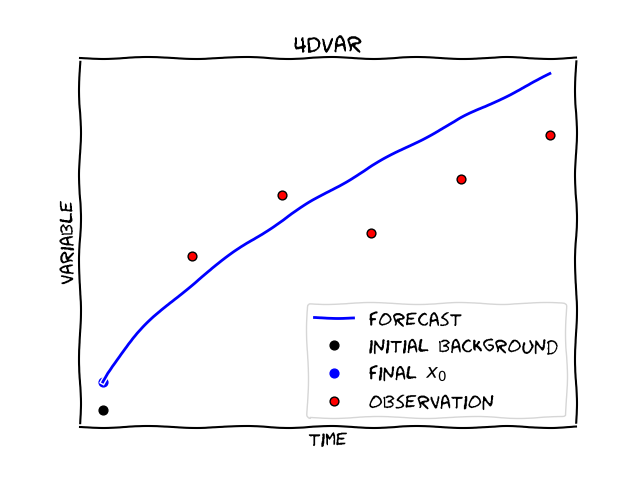

- PDE constrained optimization problem.
- Solution through adjoint methods
- Fuller details and example in the lecture notes.

#### Good things:
- Implicitly improves $B$ over time window
- uses all information in time window
- Cheaper than equivalent Kalman filter
#### Bad things:
- New $B$ not saved
- Backing out individual error bounds significant extra work
- Costlier that OI/3D-Var

## The Ensemble Kalman Filter( & friends)

- Rather than calculating $B$ with statistics, take multiple states & use sample mean, covariance, etc.
$$\overline{\mathbf{x}}_b^{k+1} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{x}_a^(i),$$
$$\mathbf{C}^{k+1}\approx \mathbf{P} := \frac{1}{N-1} \sum_{i=1}^N (\mathbf{x}_b^{(i)}-\overline{\mathbf{x}}_b)(\mathbf{x}^{(i)}-\overline{\mathbf{x}}_b)^T $$
- Use OI approach to update data only
- Cheap (but inaccurate) with small sample set
- No need to modify model/ write out adjoint.

In [ ]:
# trivial Ensemble Kalman filter for Lorenz attractor


# start by building a model
from scipy.integrate import odeint

rho = 28
sigma = 10
beta = 8/3

def f(X, t):
    """ Put the Forward Euler right hand side for Lorenz attractor"""
    
    x = X.reshape(3, len(X)//3)
    
    y = np.empty(x.shape)
    
    y[0, :] = sigma*(x[1, :]-x[0, :])
    y[1, :] = -x[0, :]*x[2, :] + rho*x[0, :]-x[1, :]
    y[2, :] = x[0, :]*x[1, :] - beta*x[2, :]
    
    return y.ravel()

x0 = np.ones(3)
t = np.linspace(0, 20, 1001)

x_t = odeint(f, x0, t).reshape(1001, 3)
    
fig = p.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*x_t[:,0:3].T)

y = x_t[100::100, 0] + np.random.normal(0, 0.1, 10)

H =np.zeros((1, 3))
H[0, 0] = 1

p.plot(y, *x_t[100::100, 1:].T , 'ro');

In [ ]:
N = 10

x_b0 = np.ones(3) + np.random.normal(0, 0.05, 3)
X_b0 = np.tile(x_b0, (N, 1)).T + np.random.normal(0, 0.05, (3, N))

X_b = np.empty([len(t), 3, N])


def C(X):
    Xmean = np.mean(X, axis=1)
    A = X - np.tile(Xmean, (N, 1)).T
    return A.dot(A.T)/(N-1)

X_b[:101, ...] = odeint(f, X_b0.ravel(), t[:101]).reshape(101, 3, N)
X_f = odeint(f, X_b0.ravel(), t).reshape(1001, 3, N)
for i in range(1, 10):
    Z = np.tile(y[i-1], (N, 1)).T - H.dot(X_b[i*100, :, :]) + np.random.normal(0, 0.1, (1, N))
    B = C(X_b[i*100, :, :])
    K = B.dot(H.T)*inv((H.dot(B.dot(H.T))+0.1**2))
    X_a = X_b[i*100, :, :] + K.dot(Z)
    X_b[i*100:(i+1)*100+1, ...] = odeint(f, X_a.ravel(), t[i*100:(i+1)*100+1]).reshape(101, 3, N)

t_y=0
    
p.figure(figsize=(15,5))
p.plot(t, x_t[:, 0], 'k--')
p.plot(t[100::100], y,'ro')
p.plot(t, X_b[:, 0,],)
p.figure(figsize=(15,5))
p.plot(t, x_t[:, 0], 'k--')
p.plot(t[100::100], y,'ro')
p.plot(t, np.mean(X_b[:, 0, :], axis=1),)
p.plot(t, np.mean(X_f[:, 0, :], axis=1),)
p.figure(figsize=(15,5))
p.plot(t, (abs(np.mean(X_b[:, 0, :], axis=1)-x_t[:, 0])), label='assimilate x[0]')
p.plot(t, (abs(np.mean(X_f[:, 0, :], axis=1)-x_t[:, 0])), label='no assimilation')
p.legend()

### You should now:

- Know a bit about probability
- Be able to recognise
 - Optimal Interpolation
 - 3D-Var
 - Kalman Filter
 - 4D-Var
- Have some idea of their properties

### Any questions?